# Определение название трека по семплу длинной 2.5 секунды.
Подход использует классификацию треков, поэтому с неизвестным системе треком - будет проблема. Данная проблема решается с помощью бинарной классификации (метод протестирован и даёт точность 93%), но в данном варианте мы будем рассматривать более простой вариант - обычная классификации треков с помощью свётночной сети.

# Принцип работы
1.  Спектрограмма (частотно-временная зависимость с учётом амплитуды звукового сигнала) - уникальна для каждого музыкального произведения 
и как отпечаток пальцев - позволяет идентифицироать музыкальную композицию.

2.  Нам известно, что любой сигнал может быть разложен в ряд Фурье и представлен набором синусоид с определённым фазовым сдвигом, частотой и амплитудой.

3.  На основании ряда Фурье можно построить хромограмму (спектрограмма, апроксимированная по наборам значений за определённый, очень короткий промежуток времени).
Таким образом хромограмма, как и спектрограмма - уникальна для каждого музыкального трека.

4.  Хромограмма является тензором второго ранга, если мы добавим третью ось, мы получим трёхмерный тензор, где на осями являются частота (Y) и время (X), а значением (3-я ось) является амплитуда сигнала в данной точке.

5.  Как видим, по своей структуре данный тензор очень похож на тензор изображения, а поэтому для обработки логично применить к нему свёрточную нейронную сеть.

6.  Музыкальную композицию можно разбить на скользящие окна, продолжительностью 1 * 100/(22050/512) ~= 2,322 секунды, 
*  где 22050 - частота дискретизации, берётся значение 0.5 от стандартной частоты в 44100 Гц.
*  512 - выборка для отдельного участка спектрограммы
*  100 - длинна окна (в количестве выборок)
*  1 - шаг смещения окна

7.  Хромограммы перекрывают друг друга и отстоят на очень небольшое расстояни - 0,0232 секунды. За это время музыкальная композиция практически не меняется.

8.  Взяв произвольный отрезок тестовой композиции длинной свыше 2,322 секунды - мы можем вырезать из тестовой композиции фрагмент, равный длинне нашего окна и сравнить его с образцом с помощью сврточной нейронной сети.


In [ ]:
pip install pydub

In [ ]:
import os
import time
import random

import pandas as pd
import numpy as np

import librosa
import librosa.display
import IPython
import soundfile
from pydub import AudioSegment

import matplotlib.pyplot as plt

from google.colab import files

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # INFO and WARNING messages are not printed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Создадим класс для работы с аудио-сигналом.
Испоьзование данного класса в десятки раз ускорит разарботку похожих проектов на вышеуказанном принципе работы

Необходимо создать соответствующие папки, указанные в конструкторе класса и указать абслоютный путь до них

In [ ]:
class DanAudio:
  def __init__(self):
    # Настройки
    self.root_dir = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/'  # Корневая директория
    self.mp3_dir = 'audio/mp3'  # Директория образцовых mp3 файлов 
    self.wav_dir = 'audio/wav'  # Директория для образцовых wav файлов модели
    self.test_wav_dir = 'audio/test'  # Директория тестовых файлов
    self.csv_dir = 'csv'  # Директория датасета
    self.class_num = 10  # Количество классов
    self.epochs = 100  # Количество эпох обучения
    self.sample_len = 100  # Длина семпла - количество выборок. (512/22050)*100 ~= 2.32 с. Отрезок аудио, по которому распознаётся трек.
    self.hop_len = 512  # Длина выборки. Частота дискретизации = 22050. Соответственно выборка будет длинной 512/22050 = 0,0232 с.
    self.__model = False

  # Создаём файлы формата wav(моно) из mp3(стерео)
  def mp3_to_wav(self):
    print("\n----- MP3_TO_WAV -----")
    files = os.listdir(self.root_dir + self.mp3_dir)
    # Фильтруем список
    mp3_list = list(filter(lambda x: x.endswith('.mp3'), files))
    print(mp3_list)
    # wav to mp3 
    i = 0
    for mp3 in mp3_list:
      mp3_file = f'{self.root_dir + self.mp3_dir}/{mp3}'
      wav_file = f'{self.root_dir + self.wav_dir}/' + mp3.replace('.mp3', '.wav')                                      
      sound = AudioSegment.from_mp3(mp3_file)
      sound = sound.set_channels(1)
      print(f'--- {wav_file} ---')
      sound.export(wav_file, format="wav")
      i += 1
      print('----- Преобразование mp3 в wav завершено -----')


  # Создание датасета csv из wav-файла
  def wav_to_dataset(self):
    print('----- WAV_TO_DATASET -----')
    files = os.listdir(self.root_dir + self.wav_dir)
    wav_list = list(filter(lambda x: x.endswith('.wav'), files))
    print('wav_list', len(wav_list), '\n', wav_list, '\n')
    self.class_num = len(wav_list)

    # Перебираем все треки
    x_list = []
    y_list = []
    track_list = []
    n = 0
    for wav in wav_list:
      track_list.append(wav)
      wav_file = f'{self.root_dir + self.wav_dir}/{wav}'
      print(wav_file)
      # wav_np - массив numpy, sr - частота дискредитации
      wav_np_full, sr = librosa.load(wav_file)

      # Обрезаем тихий сигнал вначале и в конце
      wav_np, wav_np_index = librosa.effects.trim(wav_np_full, top_db=40, frame_length=2048, hop_length=self.hop_len)

      # Вычисляем хромограмму для текущего трека
      chr = librosa.feature.chroma_stft(y=wav_np, sr=sr, n_fft=2048, hop_length=self.hop_len)  # n_fft=2048 - параметр ряда Фурье

      # Создаём датасет - x_train, y_train
      x_list, y_list = self.__get_sample_list(chr, x_list, y_list, n)
      print(f'Длина x_list: {len(x_list)}, y_list: {len(y_list)} \n')

      n += 1

    x_arr = np.array(x_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    print(f'x_arr.shape: {x_arr.shape}, y_arr: {y_arr.shape} ---\n')

    # Переводим в тензор 3 ранга
    x_arr_r = x_arr.reshape(x_arr.shape[0], 12*self.sample_len)
    x_df = pd.DataFrame(x_arr_r)
    y_df = pd.DataFrame(y_list)
    track_df = pd.DataFrame(track_list)

    # Имена файлов и пути до файлов датасета
    x_csv_file = self.root_dir + self.csv_dir + '/x_train.csv' 
    y_csv_file = self.root_dir + self.csv_dir + '/y_train.csv'
    track_file = self.root_dir + self.csv_dir + '/tracks.csv'

    # Сохраняем датасет
    x_df.to_csv(x_csv_file, index=False, encoding='utf-8')
    y_df.to_csv(y_csv_file, index=False, encoding='utf-8')
    track_df.to_csv(track_file, index=False, encoding='utf-8')

    print('Датасет сохранён')


  # Обучение моделей на датасетах
  def fit_model(self):
      csv_X_file = f'{self.root_dir + self.csv_dir}/x_train.csv'
      csv_Y_file = f'{self.root_dir + self.csv_dir}/y_train.csv'
      print(f'--- {csv_X_file} ---')

      x_df = pd.read_csv(csv_X_file, dtype=np.float32)
      x_arr = np.array(x_df)

      y_df = pd.read_csv(csv_Y_file)
      y_arr = np.array(y_df, dtype=np.float32)

      x_arr_r = x_arr.reshape((x_arr.shape[0], 12, self.sample_len, 1))

      # Создаём валидационные данные
      X_t, X_test, Y_t, Y_test = train_test_split(x_arr_r, y_arr, random_state=12, test_size=0.2)

      # X_train, Y_train - должены быть равны полной выборке, без пропусков
      X_train = x_arr_r
      Y_train = y_arr

      print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')

      # Получаем модель CNN
      model = self.__get_model()
      model.compile(optimizer='RMSprop', loss='categorical_crossentropy')

      # Обучаем модель
      self.__fit_model(X_train, X_test, Y_train, Y_test)


  # Создаём тестовые семплы длиной от 2.5 до 5 секунд по 3 семпла на каждый трек
  def creatre_test_samples(self):
    # Выводим информацию о сохранённых моделях
    wav_files = os.listdir(self.root_dir + self.wav_dir)

    for wav_file in wav_files:
      wav_np_full, sr = librosa.load(self.root_dir + self.wav_dir + '/' + wav_file)
      # Обрезаем тихий сигнал вначале и в конце
      wav_np, wav_np_index = librosa.effects.trim(wav_np_full, top_db = 40, frame_length=2048, hop_length=self.hop_len)

      for i in range(3):
        index_max = wav_np.shape[0] - 3*self.sample_len*self.hop_len  # от начала и до ~ 6.7 секунд до конца
        index_start_rand = random.randint(0, index_max)
        sample_len_rand = random.randint(self.sample_len*self.hop_len, 2*self.sample_len*self.hop_len)
        sample = wav_np[index_start_rand:index_start_rand+sample_len_rand]

        new_name = wav_file.replace('.', '_'+str(i+1)+'.')

        # Сохраняем семпл, по которому было произведено распознавание.
        soundfile.write(f'{self.root_dir}{self.test_wav_dir}/{new_name}', sample, sr)

        print(f'--- Трек сохранён: {new_name} ---')


  # Предсказание по семплу длинной 2.5 - 5 секунд.
  def predict(self, wav_file):
    track_file = f'{self.root_dir + self.csv_dir}/tracks.csv'
    track_df = pd.read_csv(track_file)

    # Загружаем аудио файл в массив numpy
    wav_np_full, sr = librosa.load(wav_file)
    # Обрезаем тихий сигнал вначале и в конце
    wav_np, wav_np_index = librosa.effects.trim(wav_np_full, top_db=40, frame_length=2048, hop_length=self.hop_len)

    # Мы обрезаем тихие участки семпла вначале и в конце - поэтому необходима проверка на длину семпла
    if wav_np.shape[0] < self.sample_len * self.hop_len:
      print('ОШИБКА: семпл короткий или содержит много тишины (тихий)')

    # Вычисляем хромограмму
    chr = librosa.feature.chroma_stft(y=wav_np, sr=sr, n_fft=2048, hop_length=self.hop_len)

    # Вырезаем отрезок длинной self.sample_len
    chroma = chr[:, 0:self.sample_len]

    # Изображение имеет 3 оси - поэтому изменяем размер матрицы.
    chroma_r = chroma.reshape((chroma.shape[0], chroma.shape[1], 1))

    # Добавляем ещё одну ось, т.к. на вход модели можно подать только тензор 4 ранга.
    # Получаем тензор 3 ранга, который потом переведём в тензор 4 ранга
    chroma_tensor = np.expand_dims(chroma_r, axis=0)
    # print('Тензор семла', chroma_tensor.shape)

    if not self.__model:
      self.__get_model()

    predicted = self.__model.predict(chroma_tensor)
    index = np.argmax(predicted[0])

    print(f'Предсказание: {track_df.iloc[index, 0]}, индекс: {index}')


  # Отображает семпл
  def plot_sample(self, audio_sample):
    # Амплитуда сигнала семпла.
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_title('Сигнал', fontsize=16)
    ax.set_xlabel('Время, с', fontsize=12)
    ax.set_ylabel('Амплитуда', fontsize=12)
    ax.set_xticks(())
    ax.plot(audio_sample)


  # Отображает хромограмму
  def plot_chroma(self, wav_np):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_title('Хромограмма семпла', fontsize=16)
    ax.set_xlabel('Выборки по времени, N', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.set_ylim([0, 12])
    im = ax.imshow(wav_np)
    fig.colorbar(im)


  # Создаём список семплов (окна длинной self.sample_len со сдвигом на одну хромограмму от начала и до конца хромограммы)
  def __get_sample_list(self, chr, x_list, y_list, n):
    # Создаём семплы - отрезки длинной self.sample_len со сдвигом на одну хромограмму от начала и до конца хромограммы
    for i in range(0, chr.shape[1], 1):
      sample = chr[:, i:i+self.sample_len]
      # Если конец хромограммы (sample.shape[1] < self.sample_len) - прерываем
      if sample.shape[1] < self.sample_len:
          break
      x_list.append(sample.tolist())  # numpy в список - быстрее работает с .append()
      y_list.append(to_categorical(n, self.class_num))
    return x_list, y_list


  # Возвращает CNN модель
  def __get_model(self):
    if self.__model:
      return self.__model
    
    print(f'Количество классов: {self.class_num}')

    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=((12, self.sample_len, 1))))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(self.class_num, activation='softmax'))

    self.__model = model
    return self.__model    


  # Обучение модели
  def __fit_model(self, X_train, X_test, Y_train, Y_test):
    print(f'--- Оучение модели, Train.shape: {X_train.shape} {Y_train.shape} Test.shape: {X_test.shape} {Y_test.shape} ---')
    history = self.__model.fit(
      X_train, 
      Y_train,
      epochs=self.epochs, 
      validation_data=(X_test, Y_test),
      batch_size=64
    )

    # Оцениваем модель
    # results = self.__model.evaluate(X_test, Y_test)
    # print(f'Оценка модели {results} \n')

In [ ]:
DAN = DanAudio()

## .mp3 -> .wav
В папке './audio/mp3' - разместим 10 треков в формате mp3.

Переведём .mp3 -> .wav

In [ ]:
DAN.mp3_to_wav()


----- MP3_TO_WAV -----
['Invincible.mp3', 'Strength of a Thousand Men.mp3', 'Dragon Rider.mp3', 'Sons Of War.mp3', 'Never Back Down.mp3', 'Freefall.mp3', 'After The Fall.mp3', 'Undying Love.mp3', 'Nero.mp3', 'Red_Tower.mp3']
--- /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Invincible.wav ---
----- Преобразование mp3 в wav завершено -----
--- /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Strength of a Thousand Men.wav ---
----- Преобразование mp3 в wav завершено -----
--- /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Dragon Rider.wav ---
----- Преобразование mp3 в wav завершено -----
--- /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Sons Of War.wav ---
----- Преобразование mp3 в wav завершено -----
--- /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавани

## Создание обучающего датасета
Берём файлы из папки './audio/wav'

Датасет сохраняем в папке './csv'

In [ ]:
DAN.wav_to_dataset()

----- WAV_TO_DATASET -----
wav_list 10 
 ['Invincible.wav', 'Strength of a Thousand Men.wav', 'Dragon Rider.wav', 'Sons Of War.wav', 'Never Back Down.wav', 'Freefall.wav', 'After The Fall.wav', 'Undying Love.wav', 'Nero.wav', 'Red_Tower.wav'] 

/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Invincible.wav
Длина x_list: 7195, y_list: 7195 

/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Strength of a Thousand Men.wav
Длина x_list: 13073, y_list: 13073 

/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Dragon Rider.wav
Длина x_list: 25494, y_list: 25494 

/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Sons Of War.wav
Длина x_list: 30233, y_list: 30233 

/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/audio/wav/Never Back Down.wav
Длина

## Обучение модели на датасе

In [ ]:
DAN.fit_model()

--- /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/8. Распознавание аудио/files/ultra_pro/csv/x_train.csv ---
X_train: (72538, 12, 100, 1), Y_train: (72538, 10)
Количество классов: 10
--- Оучение модели, Train.shape: (72538, 12, 100, 1) (72538, 10) Test.shape: (14508, 12, 100, 1) (14508, 10) ---
Epoch 1/100
1134/1134 [==============================] - 39s 5ms/step - loss: 0.9389 - val_loss: 0.0376
Epoch 2/100
1134/1134 [==============================] - 6s 5ms/step - loss: 0.0527 - val_loss: 0.0065
Epoch 3/100
1134/1134 [==============================] - 6s 5ms/step - loss: 0.0168 - val_loss: 3.4343e-04
Epoch 4/100
1134/1134 [==============================] - 6s 5ms/step - loss: 0.0092 - val_loss: 1.5179e-05
Epoch 5/100
1134/1134 [==============================] - 6s 5ms/step - loss: 0.0072 - val_loss: 2.0366e-05
Epoch 6/100
1134/1134 [==============================] - 6s 5ms/step - loss: 0.0065 - val_loss: 5.8377e-04
Epoch 7/100
1134/1134 [==============================] - 6s 5ms

## Создаём тестовые треки длиной от 2.5 до 5 секунд
Для каджого трека сделаем по 3 отрезка для тестирования - и того 30 коротких семплов, длительностью 2.5 - 5 секунд.

In [ ]:
DAN.creatre_test_samples()

--- Трек сохранён: Invincible_1.wav ---
--- Трек сохранён: Invincible_2.wav ---
--- Трек сохранён: Invincible_3.wav ---
--- Трек сохранён: Strength of a Thousand Men_1.wav ---
--- Трек сохранён: Strength of a Thousand Men_2.wav ---
--- Трек сохранён: Strength of a Thousand Men_3.wav ---
--- Трек сохранён: Dragon Rider_1.wav ---
--- Трек сохранён: Dragon Rider_2.wav ---
--- Трек сохранён: Dragon Rider_3.wav ---
--- Трек сохранён: Sons Of War_1.wav ---
--- Трек сохранён: Sons Of War_2.wav ---
--- Трек сохранён: Sons Of War_3.wav ---
--- Трек сохранён: Never Back Down_1.wav ---
--- Трек сохранён: Never Back Down_2.wav ---
--- Трек сохранён: Never Back Down_3.wav ---
--- Трек сохранён: Freefall_1.wav ---
--- Трек сохранён: Freefall_2.wav ---
--- Трек сохранён: Freefall_3.wav ---
--- Трек сохранён: After The Fall_1.wav ---
--- Трек сохранён: After The Fall_2.wav ---
--- Трек сохранён: After The Fall_3.wav ---
--- Трек сохранён: Undying Love_1.wav ---
--- Трек сохранён: Undying Love_2.wav --

## Послушаем 3 случайных трека

In [ ]:
samples = os.listdir(DAN.root_dir + DAN.test_wav_dir)

for i in range(3):
  r = random.randint(0, len(samples))
  print(samples[r])
  IPython.display.display(IPython.display.Audio(DAN.root_dir + DAN.test_wav_dir + '/' + samples[r]))

Dragon Rider_1.wav


Undying Love_3.wav


Never Back Down_1.wav


## Отображение семпла

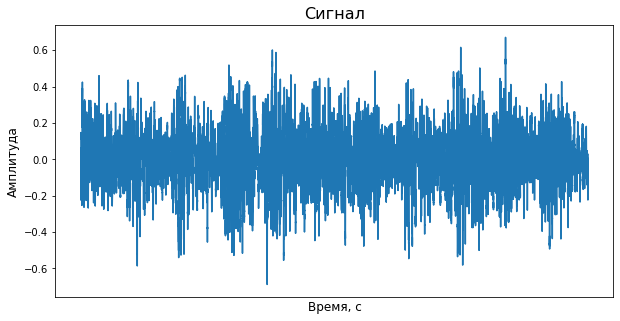

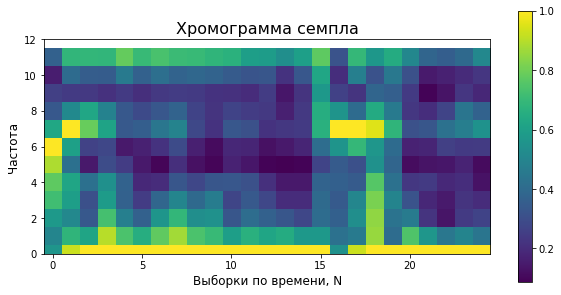

In [ ]:
wav_file = f'{DAN.root_dir}{DAN.test_wav_dir}/Invincible_1.wav'

# Загружаем аудио файл в массив numpy
wav_np, sr = librosa.load(wav_file)

# Вычисляем хромограмму
chr = librosa.feature.chroma_stft(y=wav_np, sr=sr, n_fft=2048, hop_length=DAN.hop_len)

# Вырезаем отрезок длинной self.sample_len
chroma = chr[:, 0:DAN.sample_len]

# Отобразим семпл
DAN.plot_sample(wav_np)

# Отобразим 1/4 хромограммы семпла
DAN.plot_chroma(chroma[:, 0:25])

## Протестируем работу системы.
Прогоним через систему все семплы длительностью 2.5 - 5 секунд.

In [ ]:
samples = os.listdir(DAN.root_dir + DAN.test_wav_dir)

for sample in samples:
  sample_file = DAN.root_dir + DAN.test_wav_dir + '/' + sample
  print('Семпл:', sample)
  DAN.predict(sample_file)
  print('\n')

Семпл: Invincible_1.wav
Предсказание: Invincible.wav, индекс: 0


Семпл: Invincible_2.wav
Предсказание: Invincible.wav, индекс: 0


Семпл: Invincible_3.wav
Предсказание: Invincible.wav, индекс: 0


Семпл: Strength of a Thousand Men_1.wav
Предсказание: Strength of a Thousand Men.wav, индекс: 1


Семпл: Strength of a Thousand Men_2.wav
Предсказание: Strength of a Thousand Men.wav, индекс: 1


Семпл: Strength of a Thousand Men_3.wav
Предсказание: Invincible.wav, индекс: 0


Семпл: Dragon Rider_1.wav
Предсказание: Dragon Rider.wav, индекс: 2


Семпл: Dragon Rider_2.wav
Предсказание: Dragon Rider.wav, индекс: 2


Семпл: Dragon Rider_3.wav
Предсказание: Dragon Rider.wav, индекс: 2


Семпл: Sons Of War_1.wav
Предсказание: Sons Of War.wav, индекс: 3


Семпл: Sons Of War_2.wav
Предсказание: Sons Of War.wav, индекс: 3


Семпл: Sons Of War_3.wav
Предсказание: Sons Of War.wav, индекс: 3


Семпл: Never Back Down_1.wav
Предсказание: Never Back Down.wav, индекс: 4


Семпл: Never Back Down_2.wav
Предс

# Выводы.
Допущена 1 ошибка из 30 треков. Точность составляет 97%. При этом следует учесть, что треки для теста брались из произвольных мест исходного трека и точки начала тестового окна и обучающих - не совпадали, отрезок, по которому определялся трек - 2,32c, использовался только один параметр - хромограмму, опыты с параметрами модели не производили и тем не менее - получили неплохой результат. 

## **Применение свёрточных нейронных сетей для аудиосигналов - даёт отличный результат.**

Однако применять данную модель для "промышленного кода" - нельзя. Система неверно классифицирует неизвестные ей треки. Был проведён опыт с бинарной классификацией с использованием wrong-файлов (мусорных семплов) и сильно разбалансированной (в сторону wrong-файлов) выборкой. Такой подход позволил получить неплохую точность, однако это сильно сказалось на быстродействии системы. 

Если есть идея - какой использовать подход - рад буду услышать.

Кроме того, есть несколько интересных моментов. Если заузить частотный диапазон до 300 - 3000 Гц. (либроза позволяет это сделать) - можно имитировать микрофон телефона - и определять трек по звуку. Но лучшей точности, конечно же можно добиться, если снять АЧХ микрофона телефона - перевесли в numpy и умножить на хромограмму - получим близкую копию сигнала с микрофона - что улучшит распознавание звука через телефон (аналог SHAZAM).

Однако узким звеном является быстродействие. Думаю есть иные варианты, чем бинарная классификация с wrong - файлами. Если подскажете - буду рад.

# Р.S. Следующим уроком изучаю автокодировщики. Думаю, что один из вариантов решения может лежать в этой области.